In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 769.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 40.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter



from tqdm import tqdm
from multiprocessing import Pool, cpu_count


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Encoding and Vectorizing Text

In [4]:
train_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/train_df.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/validation_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/test_df.pkl')

In [5]:
# getting the training, validation, and test text
train_text = train_df['lyrics'].tolist()
validation_text = validation_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

# getting the training, validation, and test label
train_label = train_df['mapped_genres'].tolist()
validation_label = validation_df['mapped_genres'].tolist()
test_label = test_df['mapped_genres'].tolist()

In [6]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
validation_text = [preprocess_text(text) for text in validation_text]
test_text = [preprocess_text(text) for text in test_text]

In [7]:
# encoding the labels
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
validation_label = encode_label.fit_transform(validation_label)
test_label = encode_label.fit_transform(test_label)

In [8]:
# initializeing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(validation_text)
X_test = tfidf_vectorizer.transform(test_text)


In [9]:
# scaling tf-idf feature
scaler = StandardScaler(with_mean = False)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

# Predicting the Most Common Class for Genre

In [10]:
# finding the most commong class
most_common_class = Counter(train_label).most_common(1)[0][0]
print(f'The most common class (encoded): {most_common_class}')

# getting the label for the most common class
most_common_class_label = encode_label.inverse_transform([most_common_class])[0]
print(f'Label for the most common class: {most_common_class_label}')

The most common class (encoded): 0
Label for the most common class: Alternative


In [11]:
# predicting the most common class
train_predict_common_class = [most_common_class] * len(train_label)
val_predict_common_class = [most_common_class] * len(validation_label)
test_predict_common_class = [most_common_class] * len(test_label)

In [12]:
train_accuracy_common_class = accuracy_score(train_label, train_predict_common_class)
print(f'Training accuracy (Most common class): {train_accuracy_common_class}')
print(classification_report(train_label, train_predict_common_class, target_names = encode_label.classes_))

val_accuracy_common_class = accuracy_score(validation_label, val_predict_common_class)
print(f'Validation accuracy (Most common class): {val_accuracy_common_class}')
print(classification_report(validation_label, val_predict_common_class, target_names = encode_label.classes_))

test_accuracy_common_class = accuracy_score(test_label, test_predict_common_class)
print(f'Test accuracy (Most common class): {test_accuracy_common_class}')
print(classification_report(test_label, test_predict_common_class, target_names = encode_label.classes_))

Training accuracy (Most common class): 0.22486628367670364
                precision    recall  f1-score   support

   Alternative       0.22      1.00      0.37      9081
Country & Folk       0.00      0.00      0.00      4282
    Electronic       0.00      0.00      0.00      4950
 Hip Hop & Rap       0.00      0.00      0.00      1951
  Jazz & Blues       0.00      0.00      0.00       851
           Pop       0.00      0.00      0.00      8190
          Rock       0.00      0.00      0.00      9074
   Soul & Funk       0.00      0.00      0.00      2005

      accuracy                           0.22     40384
     macro avg       0.03      0.12      0.05     40384
  weighted avg       0.05      0.22      0.08     40384

Validation accuracy (Most common class): 0.23494453248811412
                precision    recall  f1-score   support

   Alternative       0.23      1.00      0.38      1186
Country & Folk       0.00      0.00      0.00       507
    Electronic       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Logistic Regression

In [13]:
# initalizing logistic regression for baseline model
logreg_model = LogisticRegression(max_iter=5000, solver='liblinear')

# fitting the model
logreg_model.fit(X_train_scale, train_label)

# evalutating the baseline model for test set
train_predict = logreg_model.predict(X_train_scale)
train_accuracy = accuracy_score(train_label, train_predict)
print(f'Train Accuracy: {train_accuracy}')

#evaluation the baseline model for validation set
val_predict = logreg_model.predict(X_val_scale)
val_accuracy = accuracy_score(validation_label, val_predict)
print(f'Validation Accuracy:{val_accuracy}')

Train Accuracy: 0.8594988114104596
Validation Accuracy:0.3536053882725832


In [14]:
#evalutating the baseline for test set

test_predict = logreg_model.predict(X_test_scale)
test_accuracy = accuracy_score(test_label, test_predict)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.35519017432646594


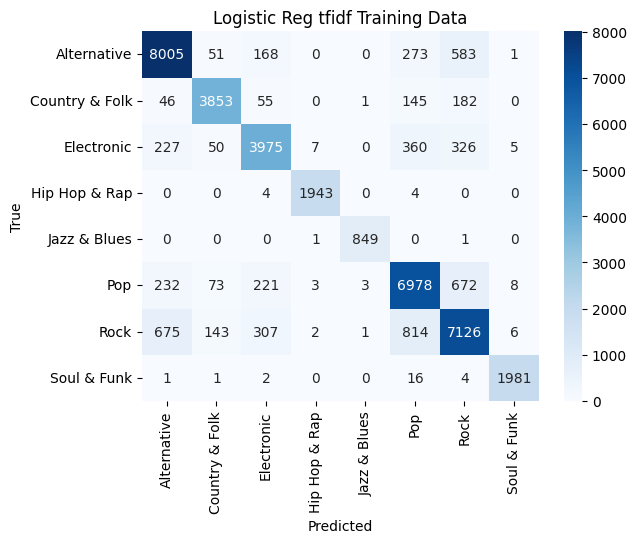

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cm = confusion_matrix(train_label, train_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Training Data')
plt.show()

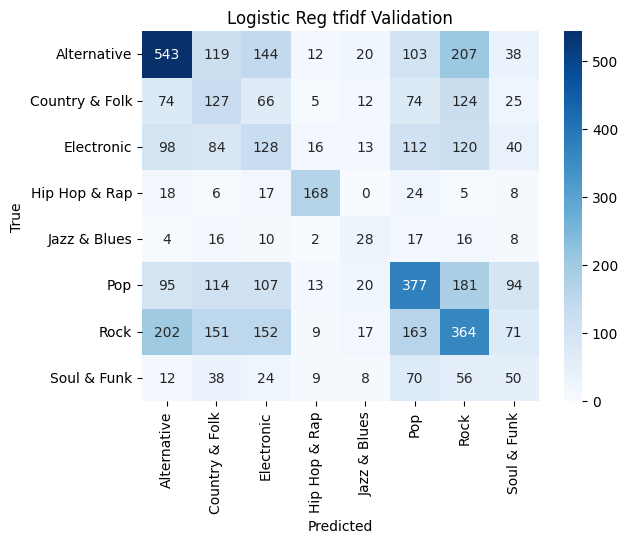

In [16]:
cm = confusion_matrix(validation_label, val_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Validation')
plt.show()


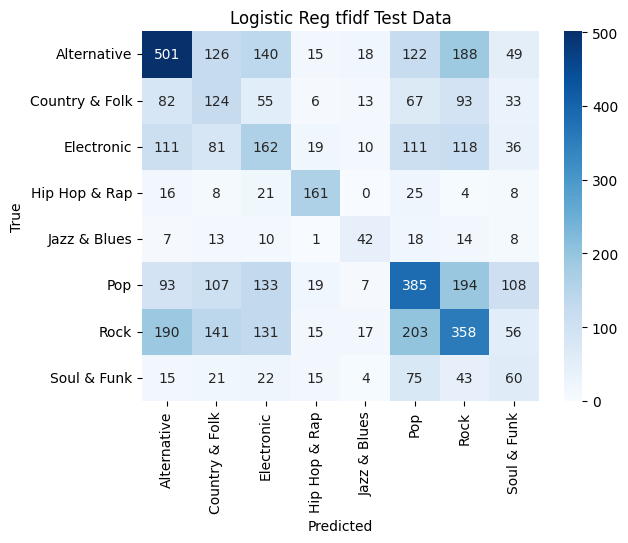

In [17]:
cm = confusion_matrix(test_label, test_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Test Data')
plt.show()